In [1]:
from IPython.display import clear_output
!pip install pytorch_lightning
!pip install pytesseract
!pip install --upgrade --force-reinstall --no-deps albumentations
!sudo apt install tesseract-ocr
# clear_output()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.8/722.8 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 2.6 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 16 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Ge

In [2]:
!sudo apt install tesseract-ocr
!pip install pytesseract
import pytesseract
import shutil
import os
import random
try:
    from PIL import Image
except ImportError:
    import Image
# clear_output()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [3]:
!gdown --id 19nNp42l0rN1epa9AwEQEqGX5fbImMV6s

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=19nNp42l0rN1epa9AwEQEqGX5fbImMV6s
To: /content/best_model.ckpt
100% 252M/252M [00:08<00:00, 29.5MB/s]


In [4]:
!gdown --id 1xiEUoeV_L8kpd2BwHyD8Grz2OCRMGjCn
!unrar x /content/samples.rar
# clear_output()

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1xiEUoeV_L8kpd2BwHyD8Grz2OCRMGjCn
To: /content/samples.rar
100% 5.33M/5.33M [00:00<00:00, 27.0MB/s]

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/samples.rar

Creating    sample_images                                             OK
Extracting  sample_images/10.1.1.1.2013_63.bmp                             0%  OK 
Extracting  sample_images/10.1.1.1.2013_64.bmp                             0%  OK 
Extracting  sample_images/10.1.1.1.2018_4.bmp                              2%  OK 
Extracting  sample_images/10.1.1.1.2019_2.bmp                              3%  OK 
Extracting  sample_images/10.1.1.1.2020_8.bmp                            

In [5]:
import pytorch_lightning as pl
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision.models import vgg19, vgg19_bn
from collections import OrderedDict
from typing import List

import numpy as np
import pandas as pd
from albumentations import Compose
from PIL import Image
from pytesseract import image_to_string
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square, convex_hull_image
from skimage.transform import resize
from skimage.util import invert
import cv2
#from tablenet import TableNetModule
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [6]:
"""TableNet Module."""

EPSILON = 1e-15


class TableNetModule(pl.LightningModule):
    """Pytorch Lightning Module for TableNet."""

    def __init__(self, num_class: int = 1, batch_norm: bool = False):
        """Initialize TableNet Module.

        Args:
            num_class (int): Number of classes per point.
            batch_norm (bool): Select VGG with or without batch normalization.
        """
        super().__init__()
        self.model = TableNet(num_class, batch_norm)
        self.num_class = num_class
        self.dice_loss = DiceLoss()

    def forward(self, batch):
        """Perform forward-pass.

        Args:
            batch (tensor): Batch of images to perform forward-pass.

        Returns (Tuple[tensor, tensor]): Table, Column prediction.
        """
        return self.model(batch)

    def training_step(self, batch, batch_idx):
        """Get training step.

        Args:
            batch (List[Tensor]): Data for training.
            batch_idx (int): batch index.

        Returns: Tensor
        """
        samples, labels_table, labels_column = batch
        output_table, output_column = self.forward(samples)

        loss_table = self.dice_loss(output_table, labels_table)
        loss_column = self.dice_loss(output_column, labels_column)

        self.log('train_loss_table', loss_table)
        self.log('train_loss_column', loss_column)
        self.log('train_loss', loss_column + loss_table)
        return loss_table + loss_column

    def validation_step(self, batch, batch_idx):
        """Get validation step.

        Args:
            batch (List[Tensor]): Data for training.
            batch_idx (int): batch index.

        Returns: Tensor
        """
        samples, labels_table, labels_column = batch
        output_table, output_column = self.forward(samples)

        loss_table = self.dice_loss(output_table, labels_table)
        loss_column = self.dice_loss(output_column, labels_column)

        if batch_idx == 0:
            self._log_images("validation", samples, labels_table, labels_column, output_table, output_column)

        self.log('valid_loss_table', loss_table, on_epoch=True)
        self.log('valid_loss_column', loss_column, on_epoch=True)
        self.log('validation_loss', loss_column + loss_table, on_epoch=True)
        self.log('validation_iou_table', binary_mean_iou(output_table, labels_table), on_epoch=True)
        self.log('validation_iou_column', binary_mean_iou(output_column, labels_column), on_epoch=True)
        return loss_table + loss_column

    def test_step(self, batch, batch_idx):
        """Get test step.

        Args:
            batch (List[Tensor]): Data for training.
            batch_idx (int): batch index.

        Returns: Tensor
        """
        samples, labels_table, labels_column = batch
        output_table, output_column = self.forward(samples)

        loss_table = self.dice_loss(output_table, labels_table)
        loss_column = self.dice_loss(output_column, labels_column)

        if batch_idx == 0:
            self._log_images("test", samples, labels_table, labels_column, output_table, output_column)

        self.log('test_loss_table', loss_table, on_epoch=True)
        self.log('test_loss_column', loss_column, on_epoch=True)
        self.log('test_loss', loss_column + loss_table, on_epoch=True)
        self.log('test_iou_table', binary_mean_iou(output_table, labels_table), on_epoch=True)
        self.log('test_iou_column', binary_mean_iou(output_column, labels_column), on_epoch=True)
        return loss_table + loss_column

    def configure_optimizers(self):
        """Configure optimizer for pytorch lighting.

        Returns: optimizer and scheduler for pytorch lighting.

        """
        optimizer = optim.SGD(self.parameters(), lr=0.0001)
        scheduler = {
            'scheduler': optim.lr_scheduler.OneCycleLR(optimizer,
                                                       max_lr=0.0001, steps_per_epoch=204, epochs=500, pct_start=0.1),
            'interval': 'step',
        }

        return [optimizer], [scheduler]

    def _log_images(self, mode, samples, labels_table, labels_column, output_table, output_column):
        """Log image on to logger."""
        self.logger.experiment.add_images(f'{mode}_generated_images', samples[0:4], self.current_epoch)
        self.logger.experiment.add_images(f'{mode}_labels_table', labels_table[0:4], self.current_epoch)
        self.logger.experiment.add_images(f'{mode}_labels_column', labels_column[0:4], self.current_epoch)
        self.logger.experiment.add_images(f'{mode}_output_table', output_table[0:4], self.current_epoch)
        self.logger.experiment.add_images(f'{mode}_output_column', output_column[0:4], self.current_epoch)


class TableNet(nn.Module):
    """TableNet."""

    def __init__(self, num_class: int, batch_norm: bool = False):
        """Initialize TableNet.

        Args:
            num_class (int): Number of classes per point.
            batch_norm (bool): Select VGG with or without batch normalization.
        """
        super().__init__()
        self.vgg = vgg19(pretrained=True).features if not batch_norm else vgg19_bn(pretrained=True).features
        self.layers = [18, 27] if not batch_norm else [26, 39]
        self.model = nn.Sequential(nn.Conv2d(512, 512, kernel_size=1),
                                   nn.ReLU(inplace=True),
                                   nn.Dropout(0.8),
                                   nn.Conv2d(512, 512, kernel_size=1),
                                   nn.ReLU(inplace=True),
                                   nn.Dropout(0.8))
        self.table_decoder = TableDecoder(num_class)
        self.column_decoder = ColumnDecoder(num_class)

    def forward(self, x):
        """Forward pass.

        Args:
            x (tensor): Batch of images to perform forward-pass.

        Returns (Tuple[tensor, tensor]): Table, Column prediction.
        """
        results = []
        for i, layer in enumerate(self.vgg):
            x = layer(x)
            if i in self.layers:
                results.append(x)
        x_table = self.table_decoder(x, results)
        x_column = self.column_decoder(x, results)
        return torch.sigmoid(x_table), torch.sigmoid(x_column)


class ColumnDecoder(nn.Module):
    """Column Decoder."""

    def __init__(self, num_classes: int):
        """Initialize Column Decoder.

        Args:
            num_classes (int): Number of classes per point.
        """
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.8),
            nn.Conv2d(512, 512, kernel_size=1),
            nn.ReLU(inplace=True),
        )
        self.layer = nn.ConvTranspose2d(1280, num_classes, kernel_size=2, stride=2, dilation=1)

    def forward(self, x, pools):
        """Forward pass.

        Args:
            x (tensor): Batch of images to perform forward-pass.
            pools (Tuple[tensor, tensor]): The 3 and 4 pooling layer from VGG-19.

        Returns (tensor): Forward-pass result tensor.

        """
        pool_3, pool_4 = pools
        x = self.decoder(x)
        x = F.interpolate(x, scale_factor=2)
        x = torch.cat([x, pool_4], dim=1)
        x = F.interpolate(x, scale_factor=2)
        x = torch.cat([x, pool_3], dim=1)
        x = F.interpolate(x, scale_factor=2)
        x = F.interpolate(x, scale_factor=2)
        return self.layer(x)


class TableDecoder(ColumnDecoder):
    """Table Decoder."""

    def __init__(self, num_classes):
        """Initialize Table decoder.

        Args:
            num_classes (int): Number of classes per point.
        """
        super().__init__(num_classes)
        self.decoder = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=1),
            nn.ReLU(inplace=True),
        )


class DiceLoss(nn.Module):
    """Dice loss."""

    def __init__(self):
        """Dice Loss."""
        super().__init__()

    def forward(self, inputs, targets, smooth=1):
        """Calculate loss.

        Args:
            inputs (tensor): Output from the forward pass.
            targets (tensor): Labels.
            smooth (float): Value to smooth the loss.

        Returns (tensor): Dice loss.

        """
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        return 1 - dice


def binary_mean_iou(inputs, targets):
    """Calculate binary mean intersection over union.

    Args:
        inputs (tensor): Output from the forward pass.
        targets (tensor): Labels.

    Returns (tensor): Intersection over union value.
    """
    output = (inputs > 0).int()

    if output.shape != targets.shape:
        targets = torch.squeeze(targets, 1)

    intersection = (targets * output).sum()

    union = targets.sum() + output.sum() - intersection

    result = (intersection + EPSILON) / (union + EPSILON)

    return result


In [7]:
"""Marmot Dataset Module."""

from pathlib import Path
from typing import List

import numpy as np
import pytorch_lightning as pl
from albumentations import Compose
from PIL import Image
from torch.utils.data import Dataset, DataLoader


class MarmotDataset(Dataset):
    """Marmot Dataset."""

    def __init__(self, data: List[Path], transforms: Compose = None) -> None:
        """Marmot Dataset initialization.

        Args:
            data (List[Path]): A list of Path.
            transforms (Optional[Compose]): Compose object from albumentations.
        """
        self.data = data
        self.transforms = transforms

    def __len__(self):
        """Dataset Length."""
        return len(self.data)

    def __getitem__(self, item):
        """Get sample data.

        Args:
            item (int): sample id.

        Returns (Tuple[tensor, tensor, tensor]): Image, Table Mask, Column Mask
        """
        sample_id = self.data[item].stem

        image_path = self.data[item]
        table_path = self.data[item].parent.parent.joinpath("table_mask", sample_id + ".bmp")
        column_path = self.data[item].parent.parent.joinpath("column_mask", sample_id + ".bmp")

        image = np.array(Image.open(image_path))
        table_mask = np.expand_dims(np.array(Image.open(table_path)), axis=2)
        column_mask = np.expand_dims(np.array(Image.open(column_path)), axis=2)
        mask = np.concatenate([table_mask, column_mask], axis=2) / 255
        sample = {"image": image, "mask": mask}
        if self.transforms:
            sample = self.transforms(image=image, mask=mask)

        image = sample["image"]
        mask_table = sample["mask"][:, :, 0].unsqueeze(0)
        mask_column = sample["mask"][:, :, 1].unsqueeze(0)
        return image, mask_table, mask_column


class MarmotDataModule(pl.LightningDataModule):
    """Pytorch Lightning Data Module for Marmot."""

    def __init__(self, data_dir: str = "./data", transforms_preprocessing: Compose = None,
                 transforms_augmentation: Compose = None, batch_size: int = 8, num_workers: int = 4):
        """Marmot Data Module initialization.

        Args:
            data_dir (str): Dataset directory.
            transforms_preprocessing (Optional[Compose]): Compose object from albumentations applied
             on validation an test dataset.
            transforms_augmentation (Optional[Compose]): Compose object from albumentations applied
             on training dataset.
            batch_size (int): Define batch size.
            num_workers (int): Define number of workers to process data.
        """
        super().__init__()
        self.data = list(Path(data_dir).rglob("*.bmp"))
        self.transforms_preprocessing = transforms_preprocessing
        self.transforms_augmentation = transforms_augmentation
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.setup()

    def setup(self, stage: str = None) -> None:
        """Start training, validation and test datasets.

        Args:
            stage (Optional[str]): Used to separate setup logic for trainer.fit and trainer.test.
        """
        n_samples = len(self.data)
        self.data.sort()
        train_slice = slice(0, int(n_samples * 0.8))
        val_slice = slice(int(n_samples * 0.8), int(n_samples * 0.9))
        test_slice = slice(int(n_samples * 0.9), n_samples)

        self.complaint_train = MarmotDataset(self.data[train_slice], transforms=self.transforms_augmentation)
        self.complaint_val = MarmotDataset(self.data[val_slice], transforms=self.transforms_preprocessing)
        self.complaint_test = MarmotDataset(self.data[test_slice], transforms=self.transforms_preprocessing)

    def train_dataloader(self, *args, **kwargs) -> DataLoader:
        """Create Dataloader.

        Returns: DataLoader
        """
        return DataLoader(self.complaint_train, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self, *args, **kwargs) -> DataLoader:
        """Create Dataloader.

        Returns: DataLoader
        """
        return DataLoader(self.complaint_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self, *args, **kwargs) -> DataLoader:
        """Create Dataloader.

        Returns: DataLoader
        """
        return DataLoader(self.complaint_test, batch_size=self.batch_size, num_workers=self.num_workers)


In [8]:
class Predict:
    """Predict images using pre-trained model."""

    def __init__(self, checkpoint_path: str, transforms: Compose, threshold: float = 0.5, per: float = 0.005):
        """Predict images using pre-trained TableNet model.
        Args:
            checkpoint_path (str): model weights path.
            transforms (Optional[Compose]): Compose object from albumentations used for pre-processing.
            threshold (float): threshold to consider the value as correctly classified.
            per (float): Minimum area for tables and columns to be considered.
        """
        self.transforms = transforms
        self.threshold = threshold
        self.per = per

        self.model = TableNetModule.load_from_checkpoint(checkpoint_path, map_location=torch.device('cpu'))
        self.model.eval()
        self.model.requires_grad_(False)
        self.inp_img = ""

    def predict(self, image: Image) -> List[pd.DataFrame]:
        """Predict a image table values.
        Args:
            image (Image): PIL.Image to
        Returns (List[pd.DataFrame]): Tables in pandas DataFrame format.
        """
        processed_image = self.transforms(image=np.array(image))["image"]
        self.inp_img = cv2.resize(np.array(image), (896, 896))
        cv2_imshow(self.inp_img)

        table_mask, column_mask = self.model.forward(processed_image.unsqueeze(0))

        table_mask = self._apply_threshold(table_mask)
        column_mask = self._apply_threshold(column_mask)
        # print(type(table_mask))
        # print(type(column_mask))
        # print(table_mask.shape)
        # print(np.unique(table_mask))
        # print(column_mask.shape)
        # print(np.unique(column_mask))
        # cv2_imshow((table_mask*255).astype(np.uint8))
        # cv2_imshow((column_mask*255).astype(np.uint8))

        segmented_tables = self._process_tables(self._segment_image(table_mask))
        # print(type(segmented_tables[0]))
        # print(segmented_tables[0].shape)
        # for i in range(len(segmented_tables)):
        #     cv2_imshow((segmented_tables[i]*255).astype(np.uint8))

        # for table in segmented_tables:
        #     abc = self._segment_image(column_mask*table)
        #     cv2_imshow(abc*255)
        cv2_imshow(self.inp_img*cv2.merge((table_mask, table_mask, table_mask)))
        cv2_imshow(self.inp_img*cv2.merge((column_mask, column_mask, column_mask)))
        tables = []
        for table in segmented_tables:
            segmented_columns = self._process_columns(self._segment_image(column_mask * table))
            if segmented_columns:
                cols = []
                for column in segmented_columns.values():
                    #cv2_imshow(self.inp_img*cv2.merge((column, column, column)))
                    cols.append(self._column_to_dataframe(column, image))
                tables.append(pd.concat(cols, ignore_index=True, axis=1))
        return tables

    def _apply_threshold(self, mask):
        mask = mask.squeeze(0).squeeze(0).numpy() > self.threshold
        return mask.astype(int)

    def _process_tables(self, segmented_tables):
        width, height = segmented_tables.shape
        tables = []
        for i in np.unique(segmented_tables)[1:]:
            table = np.where(segmented_tables == i, 1, 0)
            if table.sum() > height * width * self.per:
                tables.append(convex_hull_image(table))

        return tables

    def _process_columns(self, segmented_columns):
        width, height = segmented_columns.shape
        cols = {}
        for j in np.unique(segmented_columns)[1:]:
            column = np.where(segmented_columns == j, 1, 0)
            column = column.astype(int)

            if column.sum() > width * height * self.per:
                position = regionprops(column)[0].centroid[1]
                cols[position] = column
        return OrderedDict(sorted(cols.items()))

    @staticmethod
    def _segment_image(image):
        thresh = threshold_otsu(image)
        bw = closing(image > thresh, square(2))
        cleared = clear_border(bw)
        label_image = label(cleared)
        return label_image

    @staticmethod
    def _column_to_dataframe(column, image):
        width, height = image.size
        column = resize(np.expand_dims(column, axis=2), (height, width), preserve_range=True) > 0.01

        crop = column * image
        white = np.ones(column.shape) * invert(column) * 255
        crop = crop + white
        ocr = image_to_string(Image.fromarray(crop.astype(np.uint8)))
        return pd.DataFrame({"col": [value for value in ocr.split("\n") if len(value) > 0]})

In [9]:
def predict(image_path: str, model_weights: str) -> List[pd.DataFrame]:
    """Predict table content.

    Args:
        image_path (str): image path.
        model_weights (str): model weights path.

    Returns (List[pd.DataFrame]): Tables in pandas DataFrame format.
    """
    import albumentations as album
    from albumentations.pytorch.transforms import ToTensorV2

    transforms = album.Compose([
        album.Resize(896, 896, always_apply=True),
        album.Normalize(),
        ToTensorV2()
    ])
    pred = Predict(model_weights, transforms)

    image = Image.open(image_path)
    print(pred.predict(image))

In [10]:
predict('/content/sample_images/prime bank ltdn_12.jpg', '/content/best_model.ckpt')

Output hidden; open in https://colab.research.google.com to view.

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/migration/migration.py:201: PossibleUserWarning: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.1.6 to v2.0.6. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file best_model.ckpt`
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvis

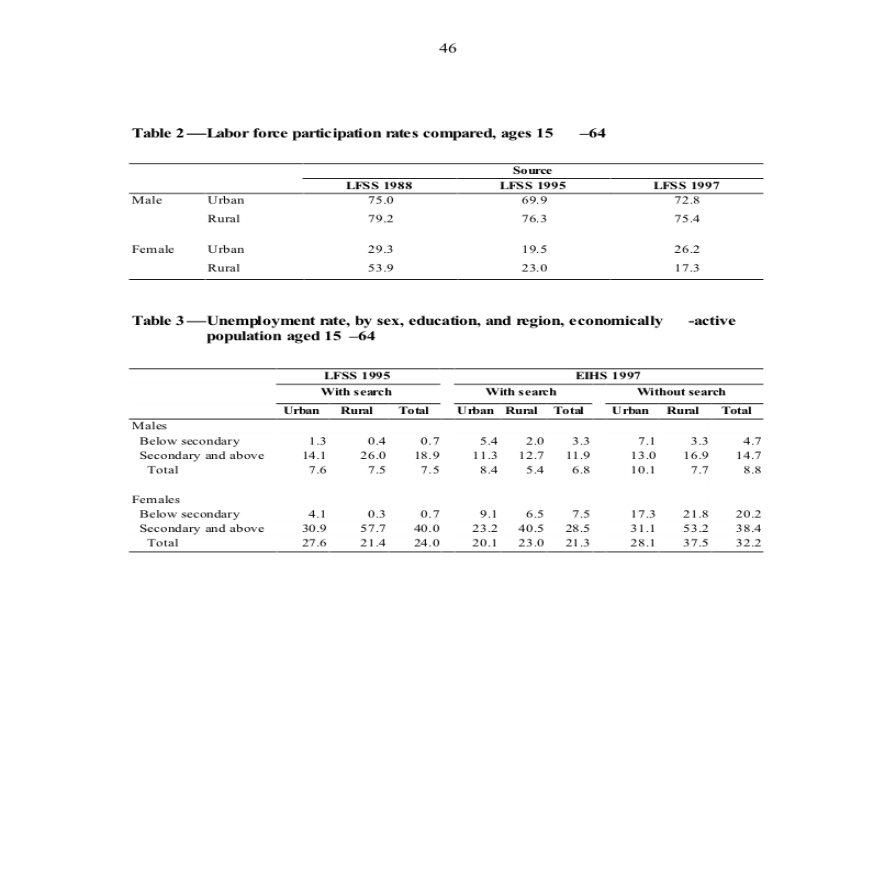

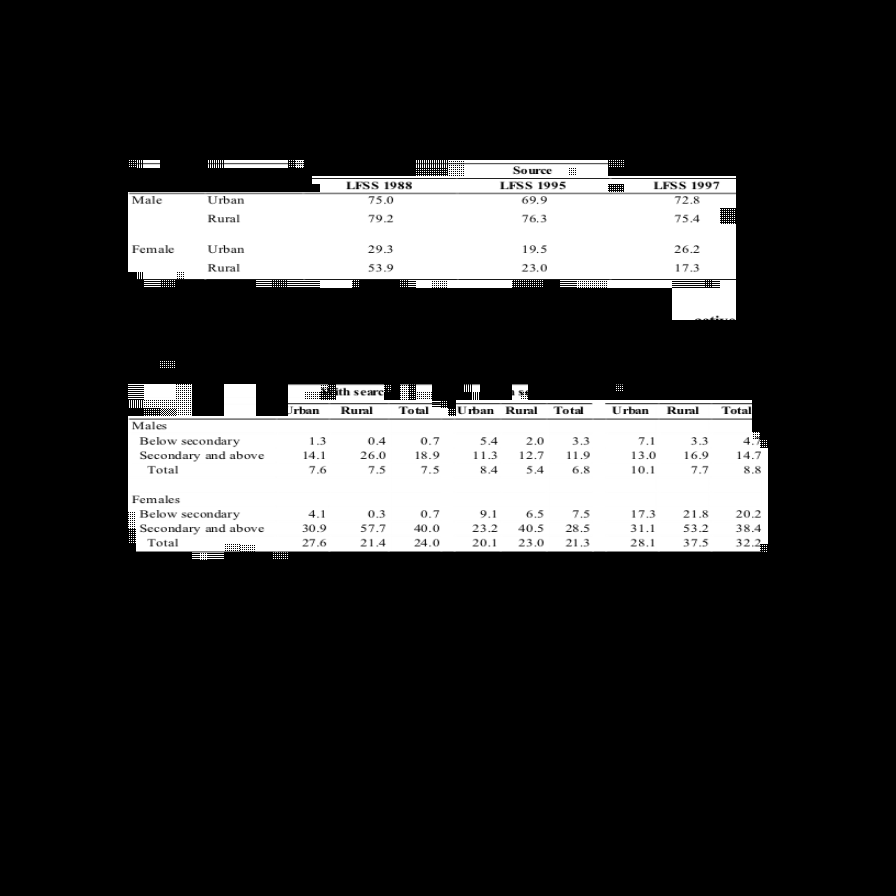

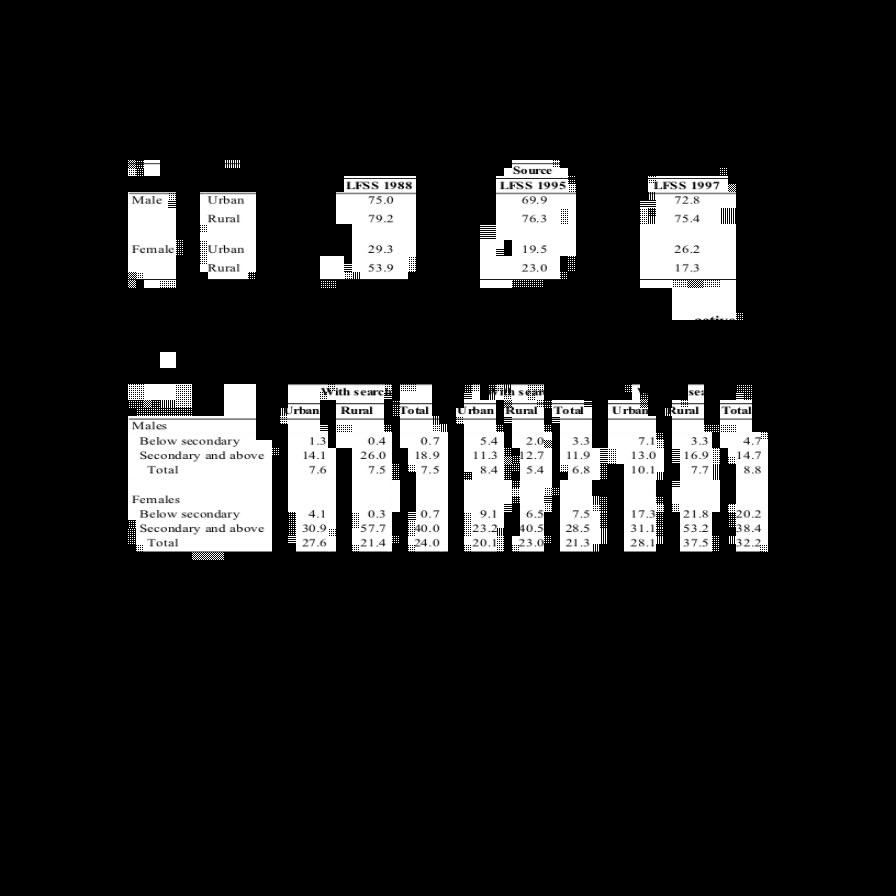

[        0      1     2    3     4
0          Urban  1988       1997
1    Male  Rural  75.0       728
2  Female  Urban  79.2  NaN  7534
3         Rural        NaN      
4     NaN          293  NaN  26.2
5     NaN         3.9  NaN   173
6     NaN    NaN       NaN     ,                       0            1     2                 3            4
0                 Males                         ~~ With sean             
1       Below secondary  With search        tian Rural Total  Rural Total
2   Secondary and above                 07                               
3                 Total               40.0                SA       330047
4               Females   Urban Rurl  24.0                 3     169 14.7
5       Below secondary        13 04                     84        17 88
6   Secondary and above      4.1 260   NaN                o4      218 202
7                 Total        16 7S   NaN              23.2     5332 384
8                             41 03   NaN                  

In [13]:
predict('/content/sample_images/10.1.1.1.2013_64.bmp', '/content/best_model.ckpt')

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/migration/migration.py:201: PossibleUserWarning: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.1.6 to v2.0.6. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file best_model.ckpt`
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvis

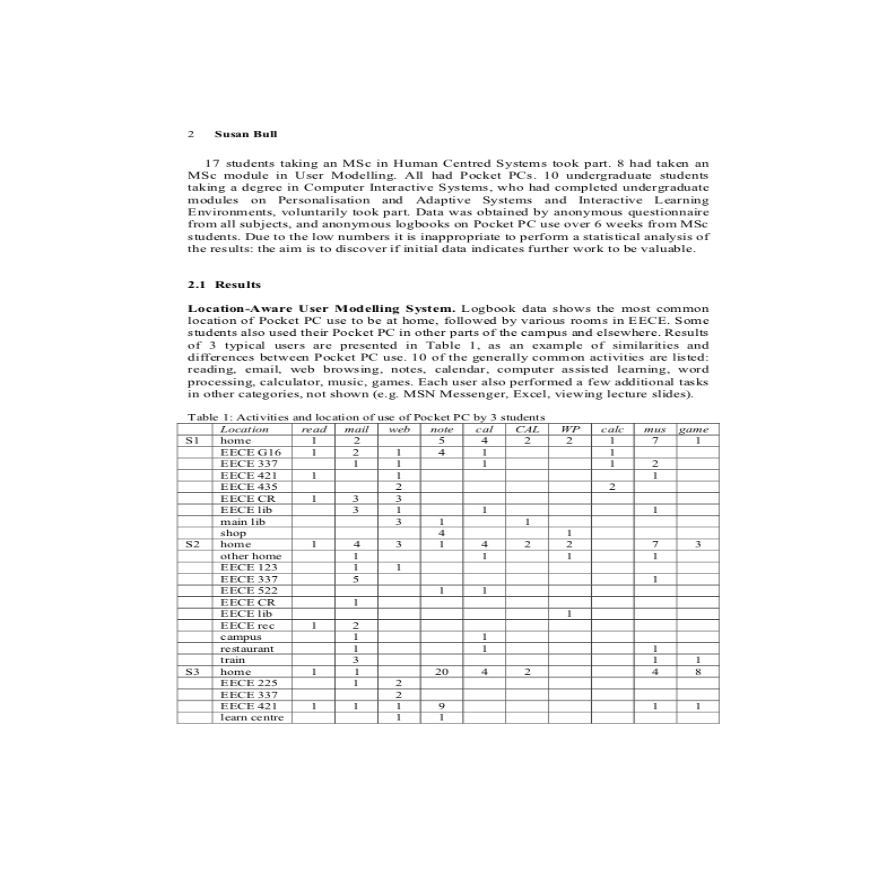

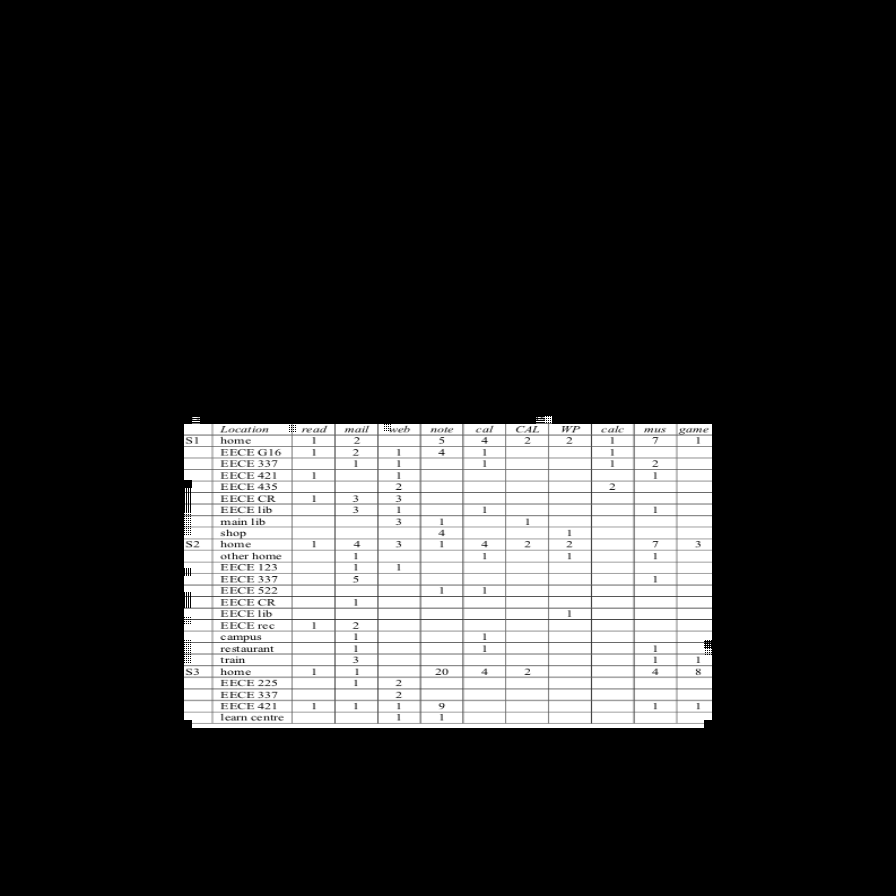

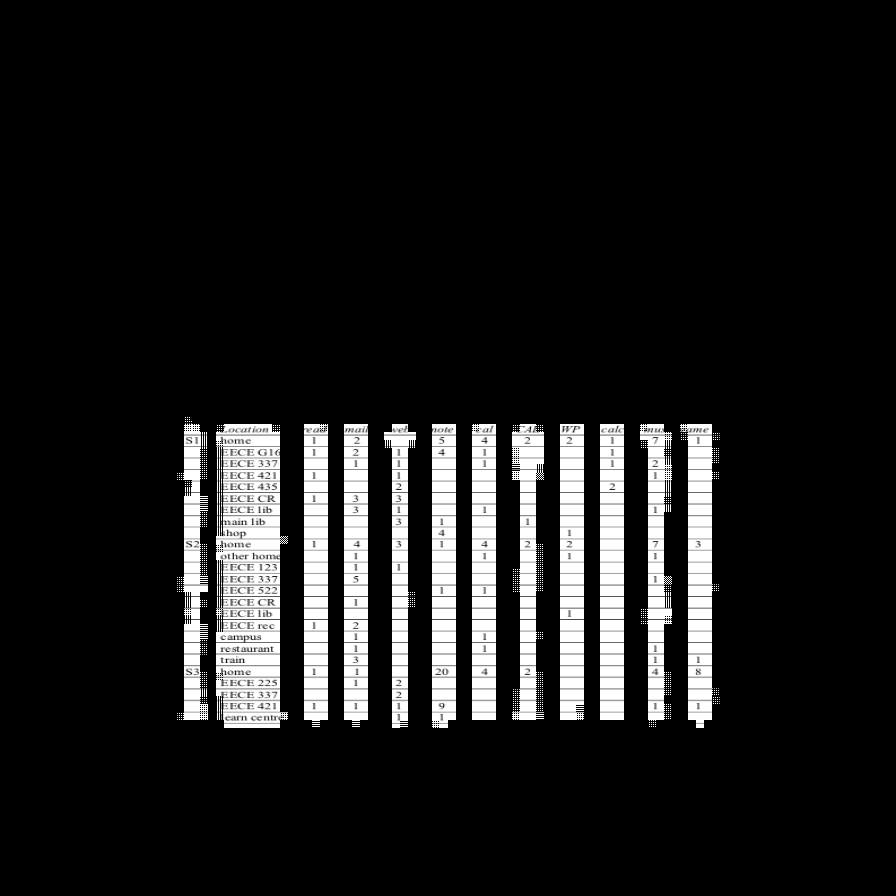

[     0            1    2                      3    4    5    6    7    8   \
0          Location      Bell | eel | lel deel                       8   
1   NaN        Thome  NaN                                    NaN       
2   NaN     EECE G16  NaN                    NaN  NaN  NaN  NaN  NaN  NaN   
3   NaN     EECE 337  NaN                    NaN  NaN  NaN  NaN  NaN  NaN   
4   NaN      ECE 421  NaN                    NaN  NaN  NaN  NaN  NaN  NaN   
5   NaN      ECE 435  NaN                    NaN  NaN  NaN  NaN  NaN  NaN   
6   NaN      EECE CR  NaN                    NaN  NaN  NaN  NaN  NaN  NaN   
7   NaN     EECE lib  NaN                    NaN  NaN  NaN  NaN  NaN  NaN   
8   NaN     main [ib  NaN                    NaN  NaN  NaN  NaN  NaN  NaN   
9   NaN        shop.  NaN                    NaN  NaN  NaN  NaN  NaN  NaN   
10  NaN        Thome  NaN                    NaN  NaN  NaN  NaN  NaN  NaN   
11  NaN  ‘other home  NaN                    NaN  NaN  NaN  NaN  NaN  NaN  

In [14]:
predict('/content/sample_images/10.1.1.1.2019_2.bmp', '/content/best_model.ckpt')

# Upper Table Detection

In [12]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import pytesseract
import pandas as pd

def table_detection(img_path):
    img = cv2.imread(img_path)
    img_s= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #plt.imshow(img_gray)
    #plt.show()
    #(thresh, img_bin) = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    (thresh, img_bin) = cv2.threshold(img_gray, 180, 255, cv2.THRESH_BINARY)
    img_bin = cv2.bitwise_not(img_bin)
    #plt.imshow(img_bin )
    #cv2.imwrite('img.jpg',img_bin)
    #plt.show()
    kernel_length_v = (np.array(img_gray).shape[1])//200
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length_v))
    im_temp1 = cv2.erode(img_bin, vertical_kernel, iterations=5)
    vertical_lines_img = cv2.dilate(im_temp1, vertical_kernel, iterations=5)

    kernel_length_h = (np.array(img_gray).shape[1])//100
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length_h, 1))
    im_temp2 = cv2.erode(img_bin, horizontal_kernel, iterations=5)
    horizontal_lines_img = cv2.dilate(im_temp2, horizontal_kernel, iterations=5)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    table_segment = cv2.addWeighted(vertical_lines_img, 0.5, horizontal_lines_img, 0.5, 0.0)
    table_segment = cv2.erode(cv2.bitwise_not(table_segment), kernel, iterations=2)
    thresh, table_segment = cv2.threshold(table_segment, 0, 255, cv2.THRESH_OTSU)

    contours, hierarchy = cv2.findContours(table_segment, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    count = 0
    dict1={}
    lst1=['shipper','consignee','notify party']
    for i,c in enumerate(contours):
        x, y, w, h = cv2.boundingRect(c)
        if (w > 0 and h > 0) :
            count += 1
            cropped = img[y-3:y + h, x-3:x + w]

            txt=pytesseract.image_to_string(cropped).strip()
            for el in lst1:
              if el in  txt.split('\n')[0].lower():
                if cropped.shape[0]<img.shape[0]/20:
                  cropped = img[y-3:y+ h+int(img.shape[0]/14), x-3:x + w]
                  txt=pytesseract.image_to_string(cropped).strip()
                dict1.update({el:' '.join(txt.split('\n')[1:])})
              img_s=cv2.rectangle(img_s,(x-3,y-3),(x + w,y + h),(255,0,0),4)



	    #cv2.imwrite("table.jpg", table_segment)
	    #cv2.imwrite("img.jpg", img)
    dict1=pd.DataFrame([dict1])
    return  dict1,img_s
path = "/content/sample_mavericks/prime bank ltdn_12.jpg"
dict2,img_s=table_detection(path)


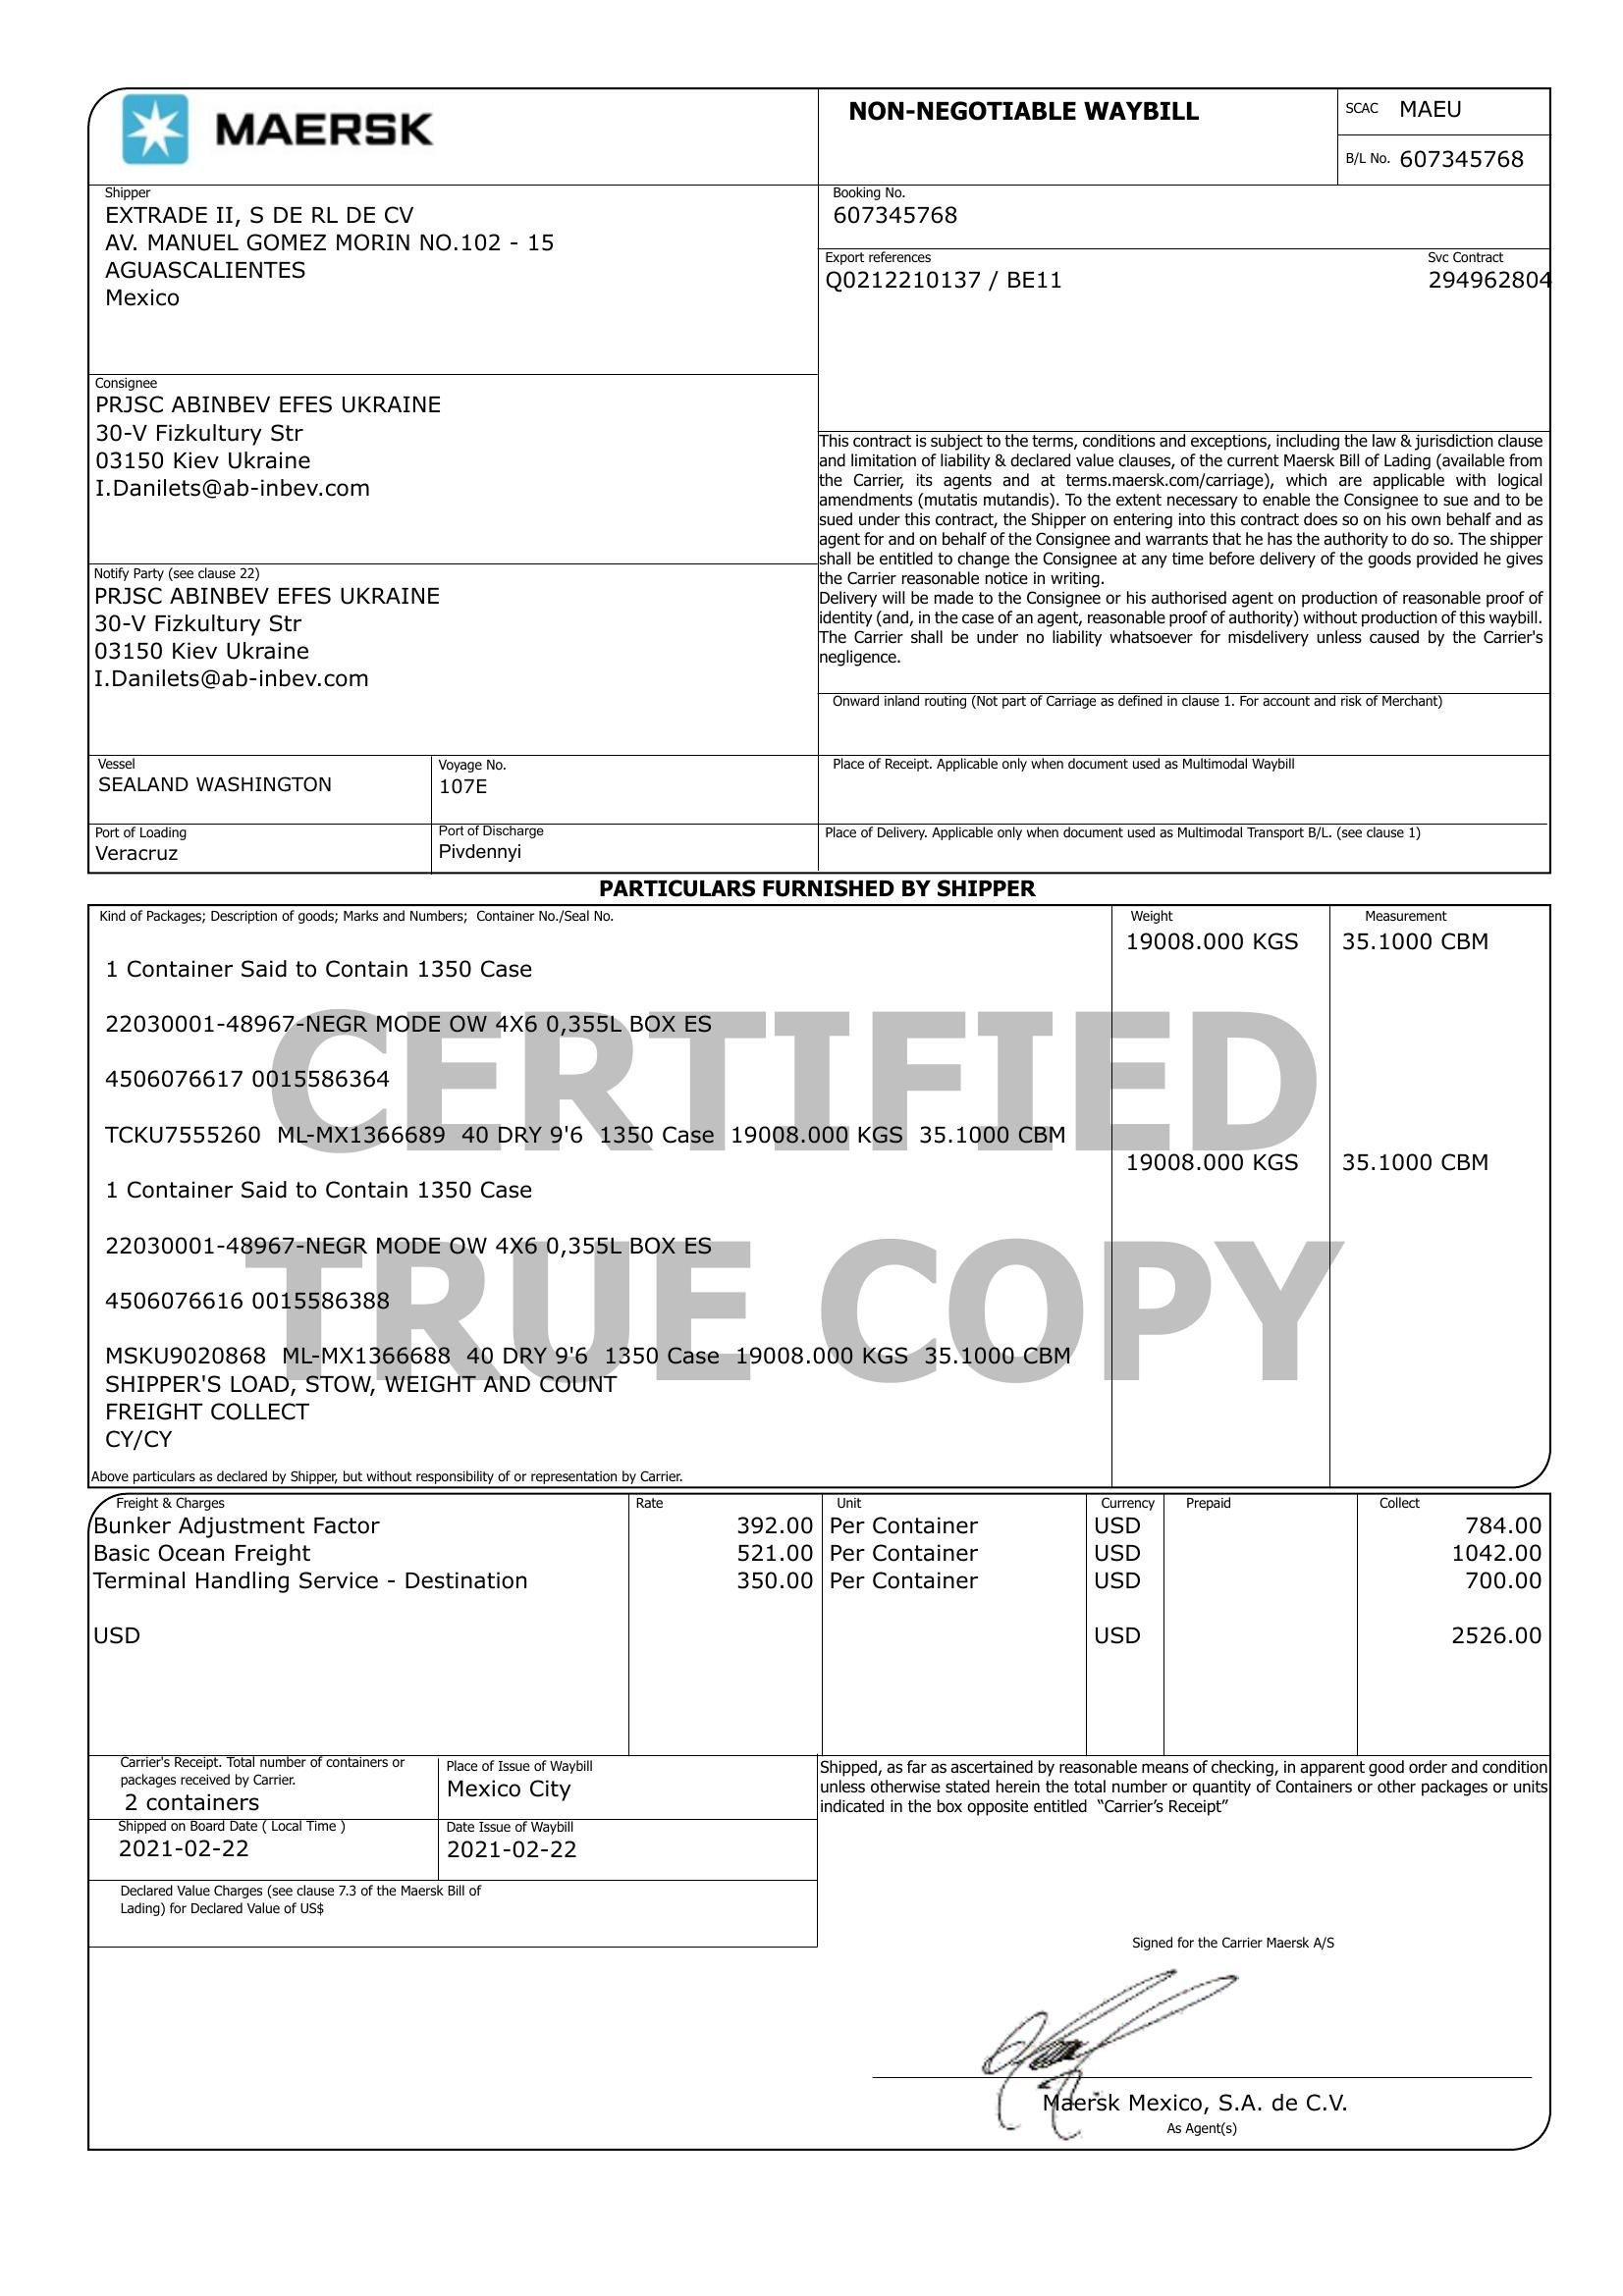

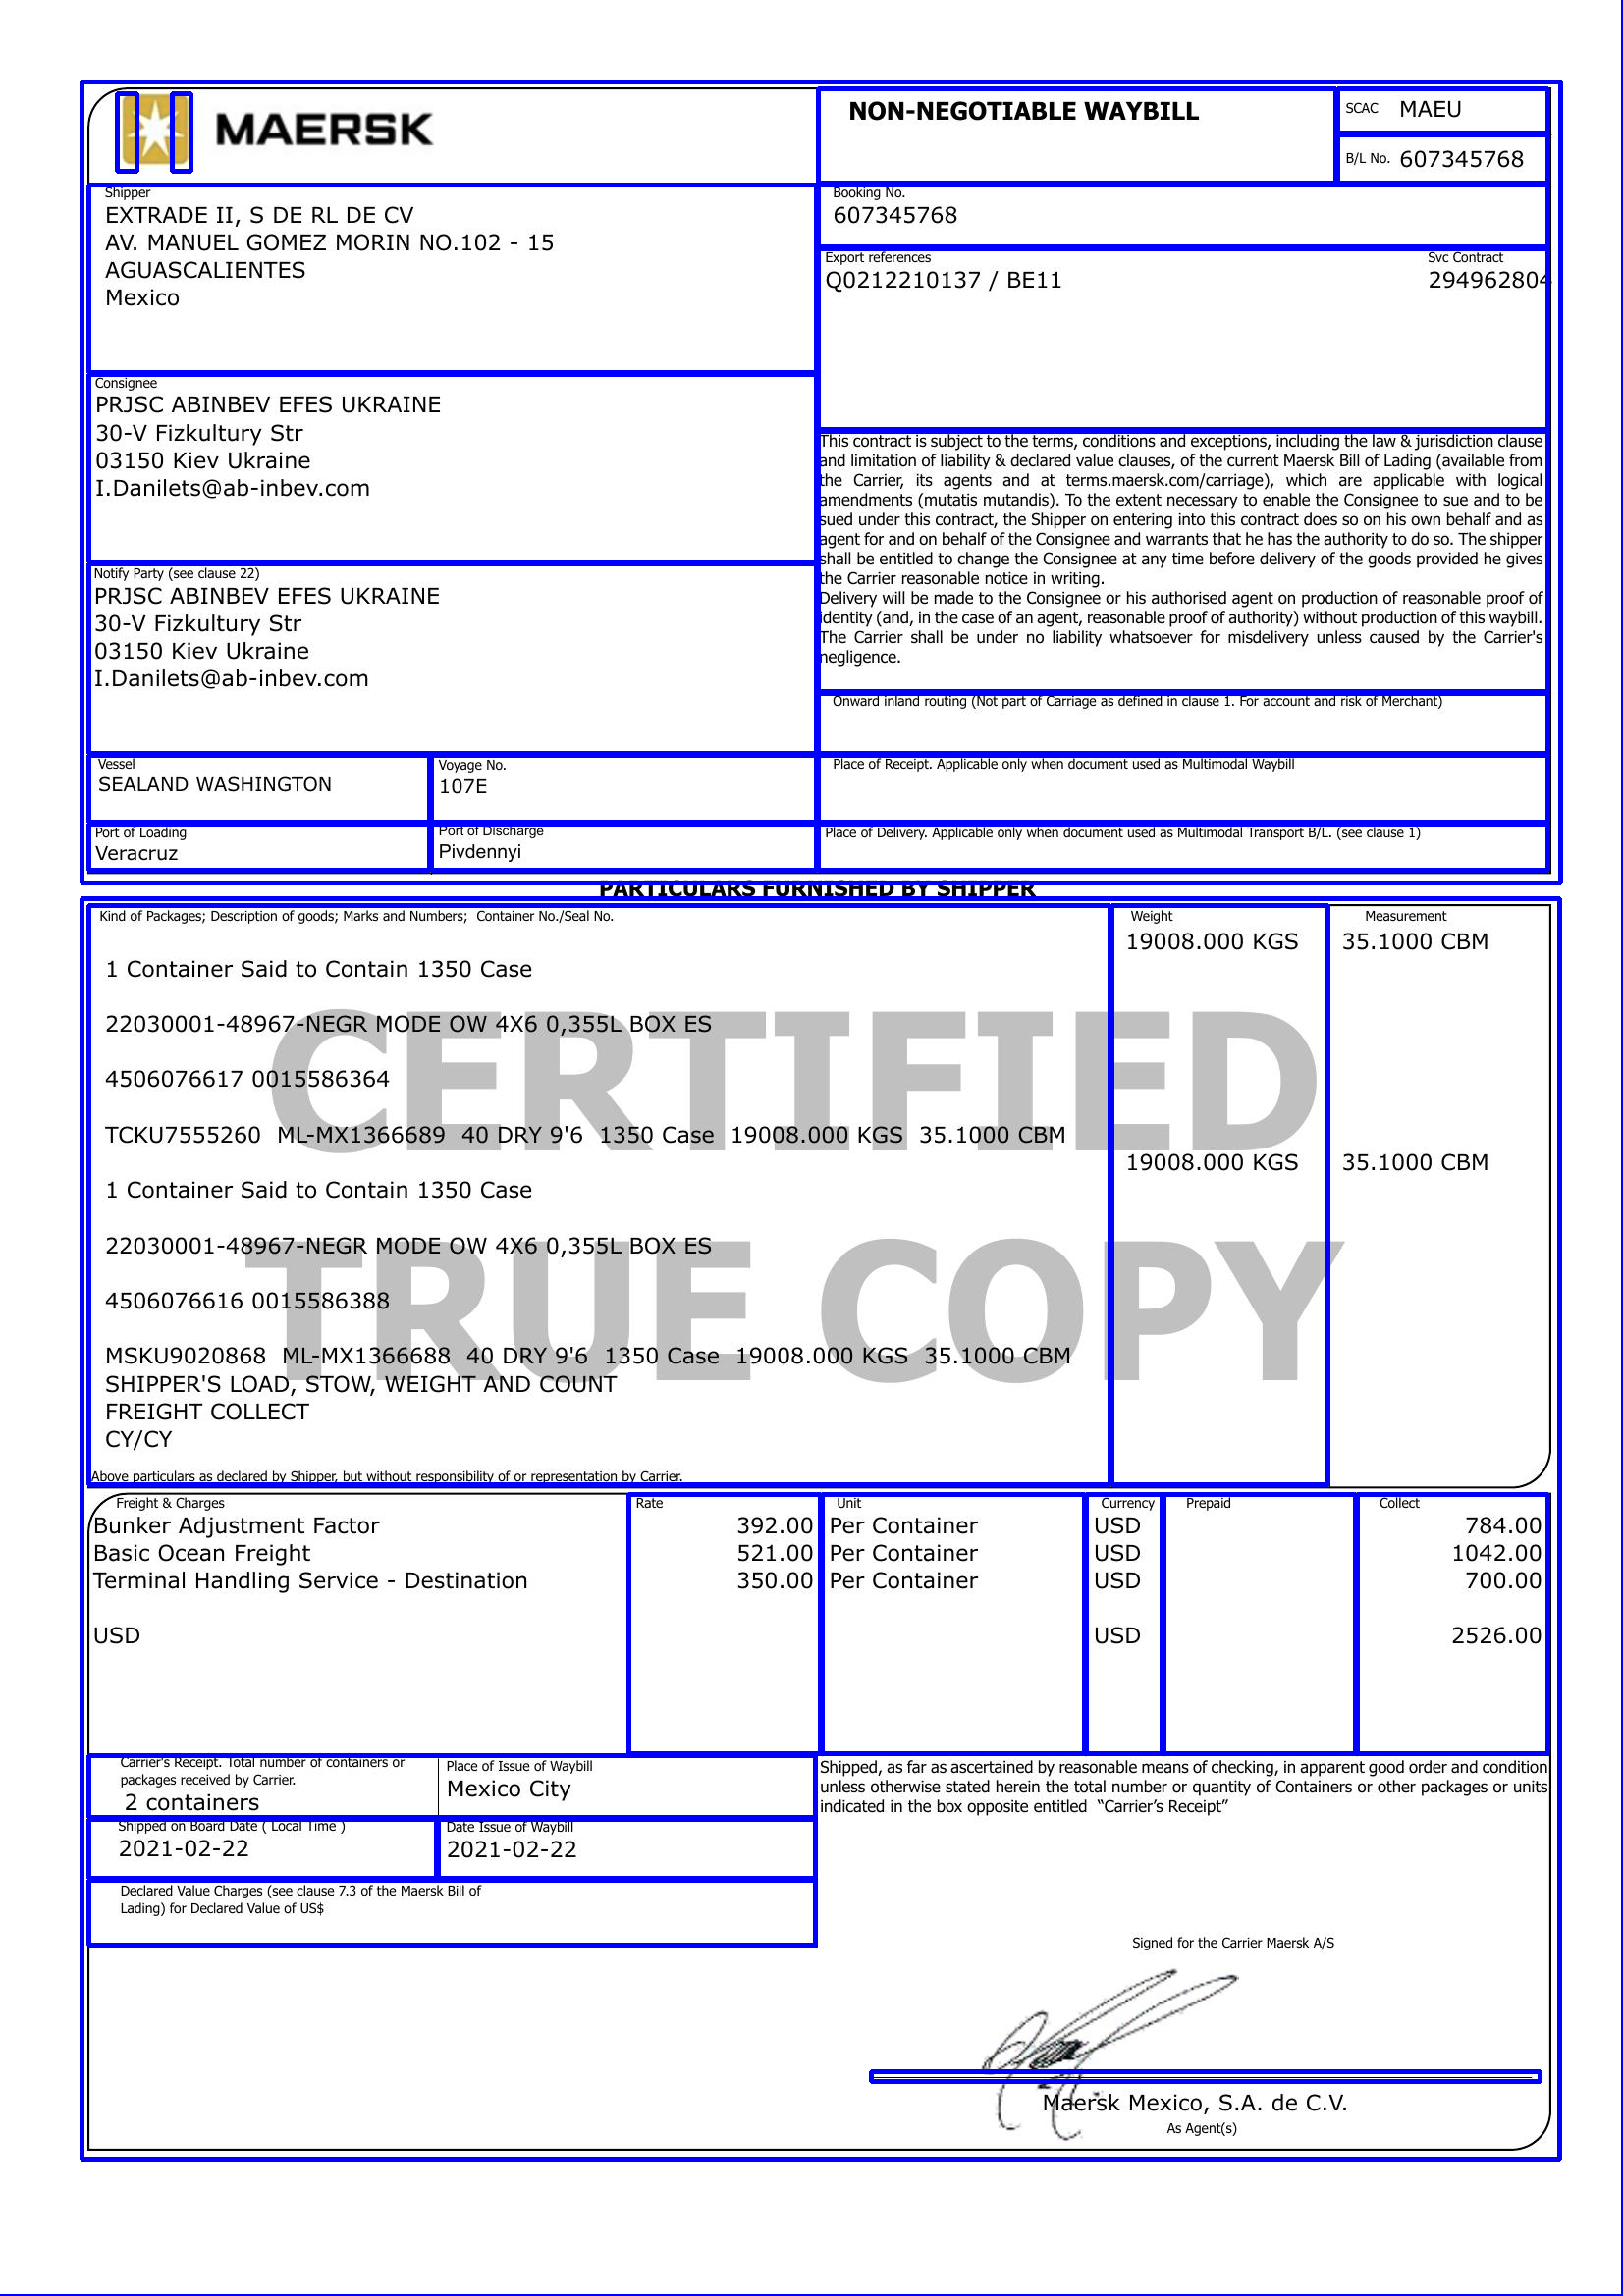

In [ ]:
cv2_imshow(cv2.imread(path))
cv2_imshow(img_s)

In [ ]:
print(dict2)

                                        notify party  \
0   PRJSC ABINBEV EFES UKRAINE 30-V Fizkultury St...   

                                           consignee  \
0   PRISC ABINBEV EFES UKRAINE 30-V Fizkultury St...   

                                             shipper  
0   EXTRADE II, S DE RL DE CV  AV. MANUEL GOMEZ M...  
